*Setup and Data Loading:*

In [ ]:
!pip install torch-summary
!pip install torchmetrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'

PATH = "/content/drive/MyDrive/PROJECT MCA RESEARCH/archive/dataset"

label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key: value for (value, key) in label2id.items()}

filenames, outcome = [], []

# Iterate over directories in PATH
for label in tqdm(os.listdir(PATH)):
    label_path = os.path.join(PATH, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        for img in os.listdir(label_path):
            filenames.append(os.path.join(label_path, img))
            outcome.append(label2id[label])

df = pd.DataFrame({
    "filename": filenames,
    "outcome": outcome
})

df = df.sample(frac=1)
df.head()


<ipython-input-2-fede980d4f3c>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
1031,/content/drive/MyDrive/PROJECT MCA RESEARCH/ar...,0
2262,/content/drive/MyDrive/PROJECT MCA RESEARCH/ar...,2
569,/content/drive/MyDrive/PROJECT MCA RESEARCH/ar...,0
536,/content/drive/MyDrive/PROJECT MCA RESEARCH/ar...,0
1043,/content/drive/MyDrive/PROJECT MCA RESEARCH/ar...,0


Data Visualization

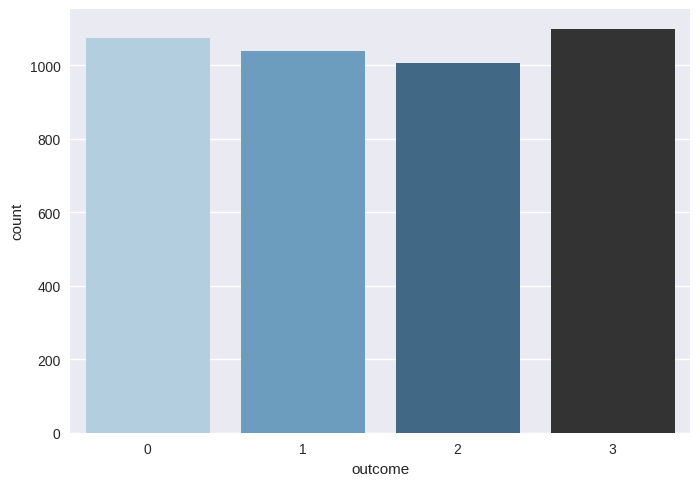

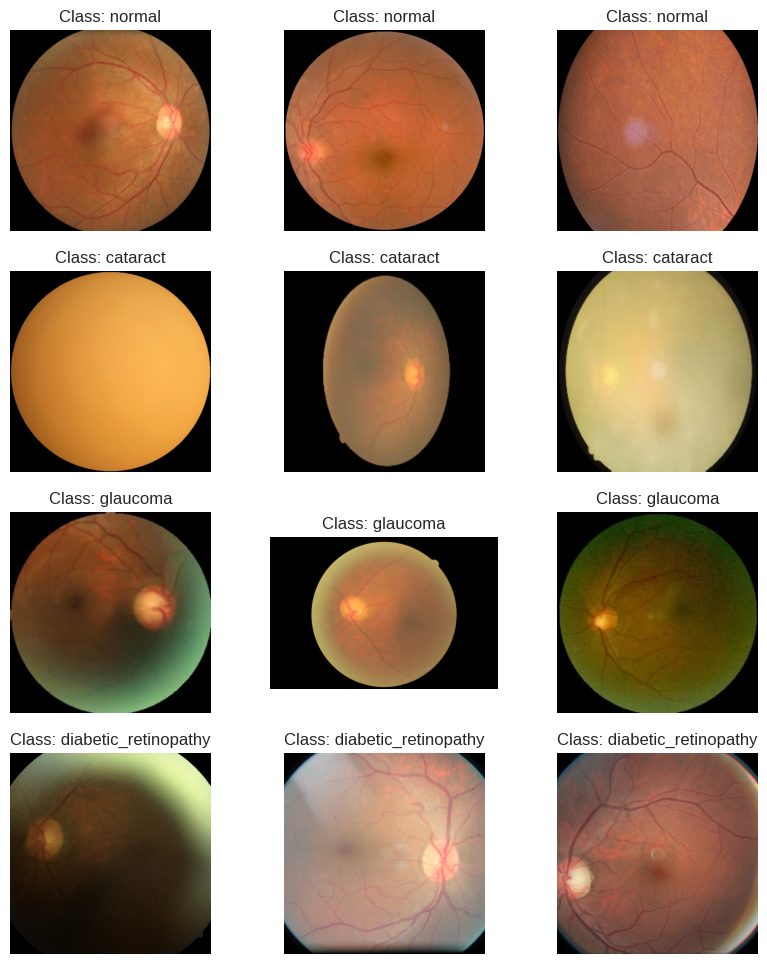

In [ ]:
import seaborn as sea

sea.countplot(x='outcome', data=df, palette='Blues_d', hue='outcome', legend=False)

def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize=(10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n=3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()


3. Data Preprocessing and Dataset Creation:

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform=None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min()) / img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.15, random_state=28)

NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)


torch.Size([128, 3, 224, 224]) torch.Size([128])


4. Model Definition:

In [ ]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained=True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.fc = nn.Identity()

    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params': self.base.parameters(), 'lr': 3e-5},
            {'params': self.block.parameters(), 'lr': 8e-4}
        ])

    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x


5. Training Setup:

In [ ]:
class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)

            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


trainer = Trainer(train_loader, val_loader, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.4MB/s]




```
# This is formatted as code
```

6. Training and Evaluation:

In [9]:
summary(trainer.model.base, (3, 224, 224))

trainer.train(epochs=5)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.202 acc: 0.921] Val: [loss: 0.267 acc:0.890]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.172 acc: 0.936] Val: [loss: 0.274 acc:0.899]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.169 acc: 0.936] Val: [loss: 0.218 acc:0.911]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.124 acc: 0.954] Val: [loss: 0.223 acc:0.912]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.126 acc: 0.952] Val: [loss: 0.215 acc:0.908]


7. Plotting training and validation loss and accuracy

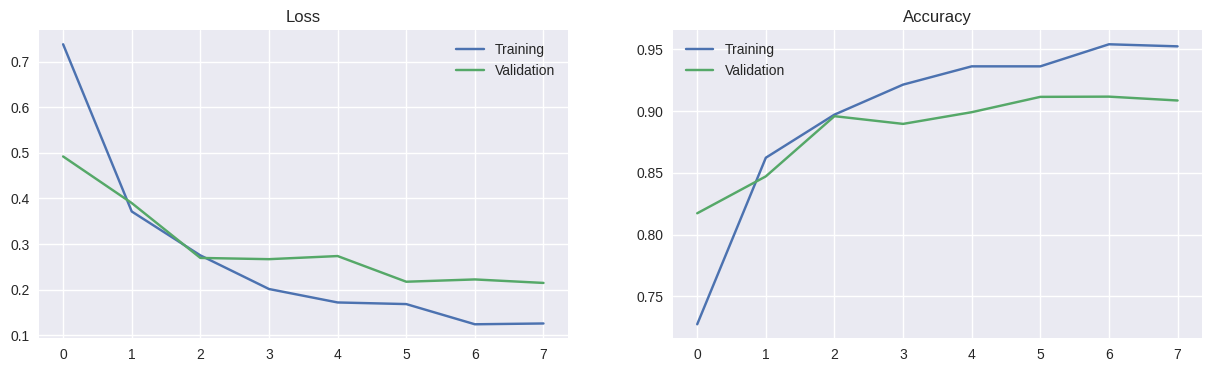

In [10]:
import matplotlib.pyplot as plt

# Plotting training and validation loss and accuracy
plt.figure(figsize=(15, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label='Training')
plt.plot(trainer.history['val_loss'], label='Validation')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label='Training')
plt.plot(trainer.history['val_acc'], label='Validation')
plt.legend()

plt.show()


8. Compute predictions and true labels for the validation set

  0%|          | 0/5 [00:00<?, ?it/s]

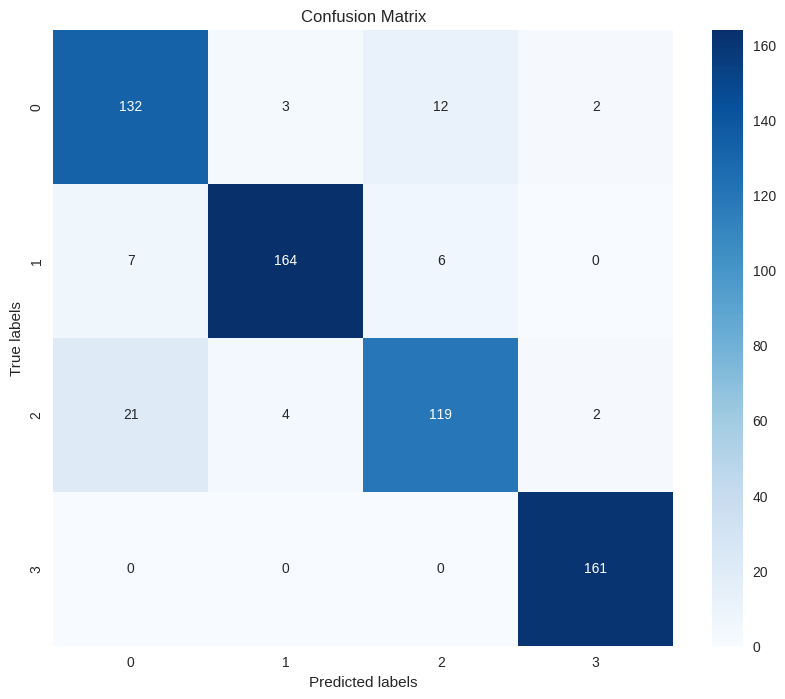

                      precision    recall  f1-score   support

              normal       0.82      0.89      0.85       149
            cataract       0.96      0.93      0.94       177
            glaucoma       0.87      0.82      0.84       146
diabetic_retinopathy       0.98      1.00      0.99       161

            accuracy                           0.91       633
           macro avg       0.91      0.91      0.91       633
        weighted avg       0.91      0.91      0.91       633



In [11]:
import seaborn as sea
from sklearn.metrics import confusion_matrix, classification_report

# Compute predictions and true labels for the validation set
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis=1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

# Compute confusion matrix
cm = confusion_matrix(true, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true, preds, target_names=label2id.keys(), zero_division=1))
